## How to: Calibrate the age-action model using an external sample of stars and their ages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import jax.numpy as jnp

import zoomies

%load_ext autoreload
%autoreload 2

# Stokholm RGB Sample

First, we read in a calibration sample of red giant branch stars with asteroseismic ages, crossmatched with Gaia.

Table from Stokholm et al. 2023 https://ui.adsabs.harvard.edu/abs/2023MNRAS.524.1634S/abstract

In [5]:
# xmatch = Table.read('../../StokholmRGB_GaiaXmatch.csv')

# # No negative parallaxes
# xmatch = xmatch[xmatch['parallax'] > 0]

The function ``calc_jz()`` calculates and saves actions (J_z, J_r, and J_phi) for calibration samples.

(This step will take a while for large samples)

In [6]:
# zoomies.calc_jz(xmatch,  mwmodel='2022', method='agama', write=True, fname='../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Read saved table with actions back in:

In [7]:
# xmatch = Table.read('../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

In [8]:

# # No Nan Jzs
# # xmatch = xmatch[~np.isnan(xmatch['Jz'])]

# # No Unreasonably large Jzs
# xmatch = xmatch[np.log(xmatch['Jz']) < 20]

We calculate an age error column from the percentile values given. We don't want negative or zero age errors.

In [9]:
# xmatch['age_err'] = np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0)
# xmatch = xmatch[xmatch['age_err'] > 0]

Write the filtered table again -- now can read in the table without doing any more cuts.

Writing/reading in the tables like this is optional, but it allows you to perform analysis only on the saved tables with calculated actions (without calculating the actions again)

In [10]:
# xmatch.write('../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [11]:
xmatch = Table.read('../../FinalFinalCode/Final_datafiles/2_StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Defining age, ln(J_z), and age error arrays

In [12]:
age = np.array(xmatch['AGE_BASTA'])/1000 # Age in Gyr
lnJz = np.array(np.log(xmatch['Jz']))
age_err = np.array(xmatch['age_err'])

Plot the calibration sample in age--action space:

Text(0.5, 1.0, 'RGB Calibration Sample')

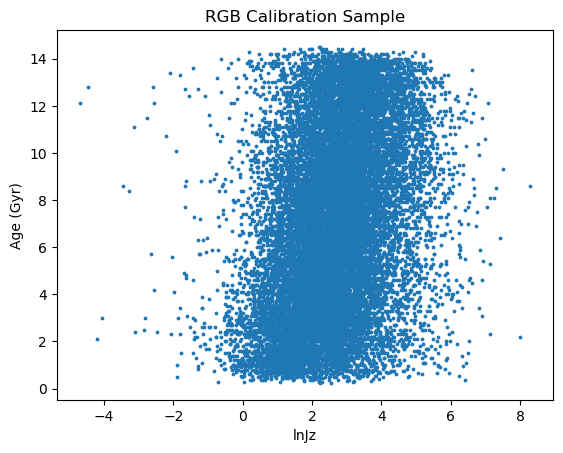

In [13]:
# Calibration sample in age-lnJz space
plt.scatter(lnJz, age, s=3)
plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')
plt.title('RGB Calibration Sample')

### Calibrating the monotonic age-lnJz spline model

First, define a KinematicAgeSpline object using ``jax`` arrays of the age, age_error, and lnJz variables we defined above:

In [54]:
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))

With ``spline.fit_mono_spline``, you can fit the age--action model (including a monotonic age--lnJz spline) using the calibration sample in one step. 

In [55]:
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Let's plot our spline model against the calibration data:

In [58]:
spline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

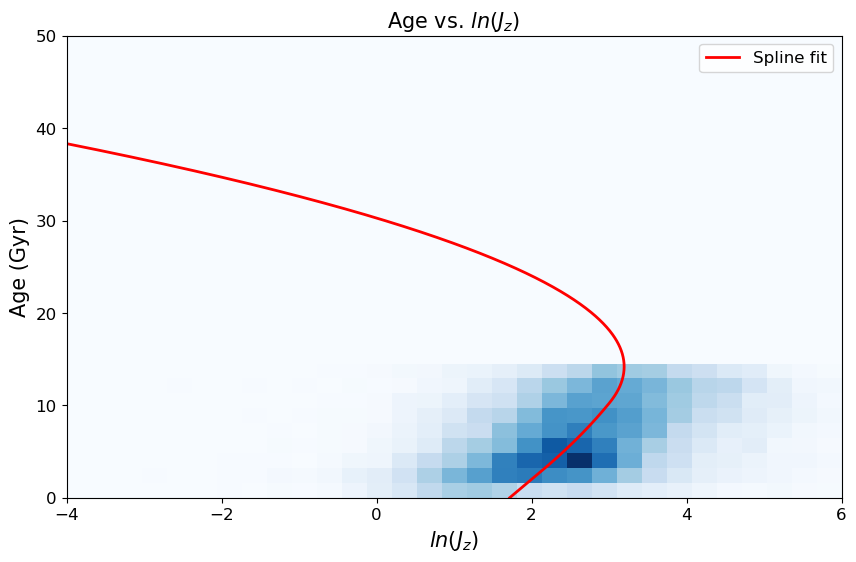

In [60]:
plt.hist2d(spline.lnJz, spline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 50, 32)), cmap='Blues')
plt.plot(spline.eval_spline, spline.grid, color='red', label='Spline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
#plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

We can take a look at the sample statistics using ``spline.inf_data``:

In [30]:
import arviz as az
az.summary(spline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.314,0.013,1.291,1.339,0.000,0.000,3207.0,2825.0,1.0
age_knot_vals[0],1.533,0.047,1.442,1.617,0.001,0.001,1247.0,1524.0,1.0
age_knot_vals[1],0.157,0.011,0.136,0.178,0.000,0.000,1130.0,1353.0,1.0
age_knot_vals[2],0.111,0.011,0.090,0.131,0.000,0.000,1324.0,1734.0,1.0
age_knot_vals[3],0.093,0.010,0.075,0.114,0.000,0.000,2028.0,2018.0,1.0
age_knot_vals[4],0.010,0.009,0.000,0.026,0.000,0.000,2433.0,1465.0,1.0
dens_knot_vals[0],4.273,0.115,4.054,4.488,0.002,0.002,2700.0,2691.0,1.0
dens_knot_vals[1],7.519,0.015,7.491,7.546,0.000,0.000,4604.0,2970.0,1.0
dens_knot_vals[2],7.421,0.014,7.395,7.447,0.000,0.000,4163.0,2637.0,1.0
dens_knot_vals[3],7.290,0.015,7.260,7.317,0.000,0.000,5400.0,2957.0,1.0


Let's write the calibrated model:

In [44]:
#spline.write(directory='../RGB_spline_model_NoTruncate/')

And read it back in just for fun

In [45]:
#newspline = zoomies.read(directory='../RGB_spline_model_NoTruncate/')

``newspline`` has all the same attributes as ``spline``, so you can fit the model once and read it in again and again to generate age predictions for other stars.

In [48]:
newspline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

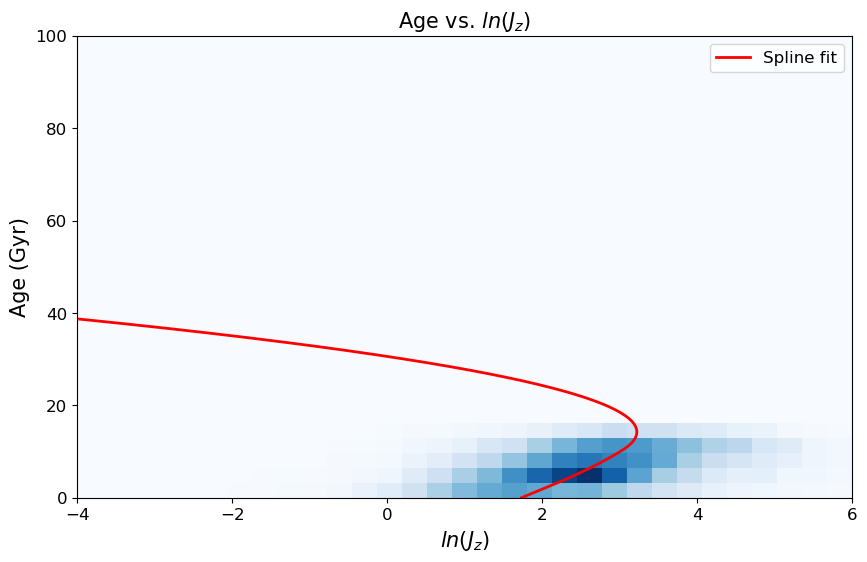

In [50]:
plt.hist2d(newspline.lnJz, newspline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 100, 32)), cmap='Blues')
plt.plot(newspline.eval_spline, newspline.grid, color='red', label='Spline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
#plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

Using the ``KinematicAgeSpline.evaluate_ages()`` function, you can generate a predicted age probability distribution for any value of ln($J_z$).

``evaluate_ages()`` returns two things:

``eval_grid`` is the test age array upon which the age probabilities are evaluated.

``eval_pdf`` is the kinematic age probability at each point in ``eval_grid``.

Plotting ``eval_pdf`` vs. ``eval_grid`` gives you the kinematic age probability density function.

In [51]:
# evaluate_ages() takes an argument of ln(Jz).

eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

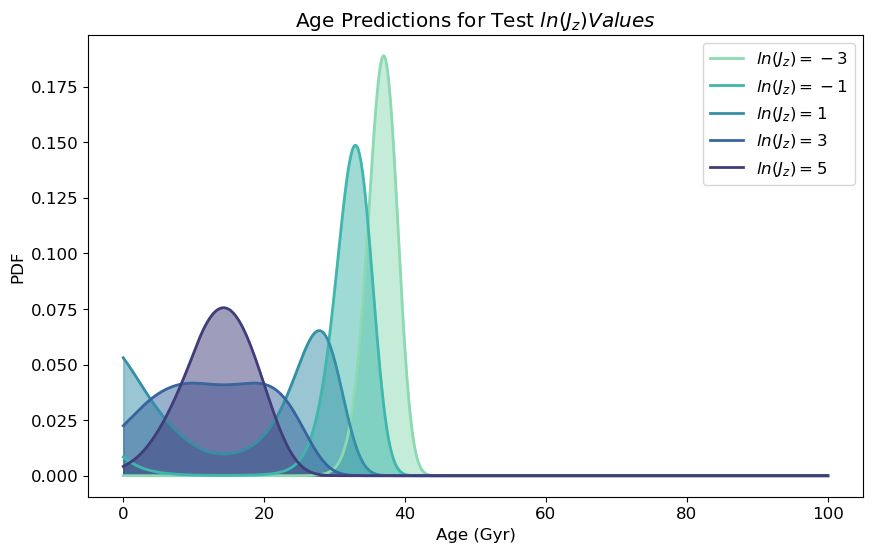

In [52]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

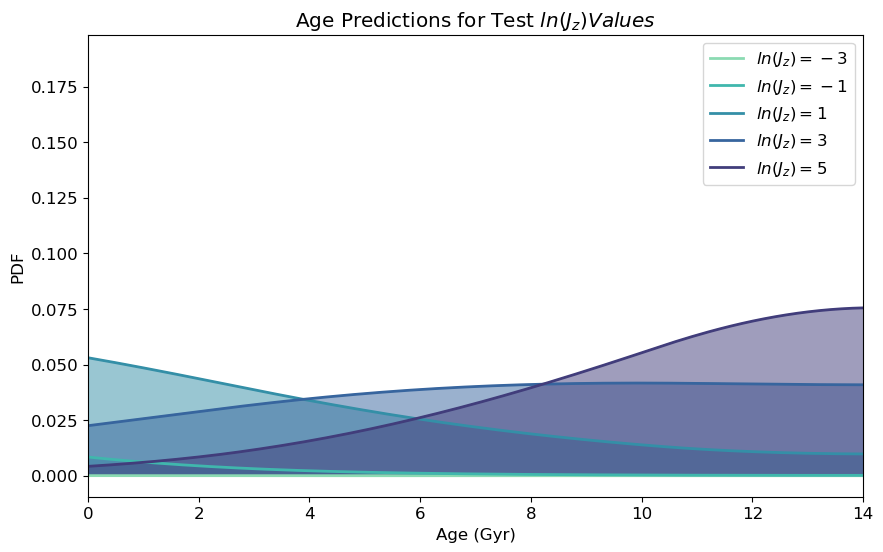

In [53]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.xlim(0,14)

plt.title('Age Predictions for Test $ln(J_z) Values$')

In [20]:
kepler_ages = Table.read('../../Kepler_Age_Predictions.fits')
kep42 = np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz'])
kep125 = np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz'])
kep186 = np.log(kepler_ages[kepler_ages['kepid'] == 8120608]['Jz'])
kep249 = np.log(kepler_ages[kepler_ages['kepid'] == 7907423]['Jz'])
kep236 = np.log(kepler_ages[kepler_ages['kepid'] == 4725681]['Jz'])

In [24]:
# kep42 = 3.6486240894109683
# kep125 = -0.9615162137394352
# kep186 = -1.657133801967237
# kep249 = 0.9103696829926338
# kep236 = -0.39834222813493686

Text(0.5, 1.0, 'Age Predictions for M Dwarf Planet Hosts')

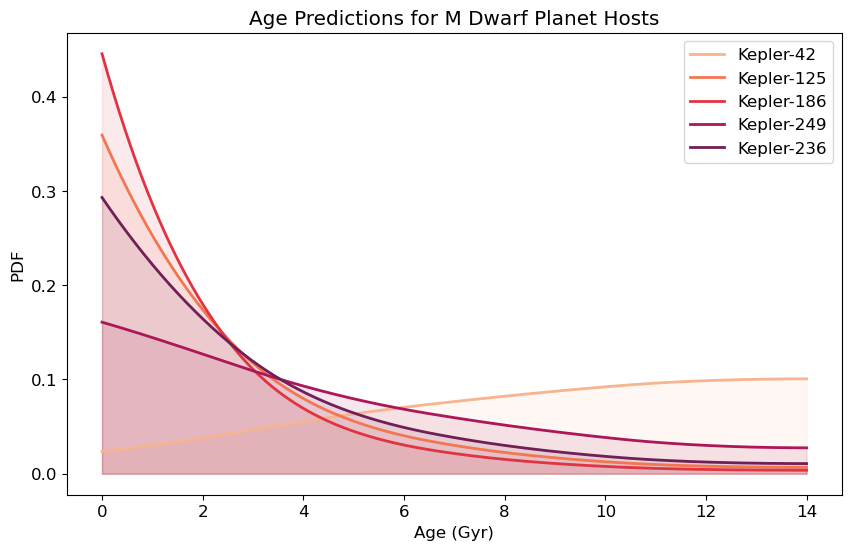

In [25]:
eval_grid, eval_pdf_kep42 = spline.evaluate_ages(kep42)
_, eval_pdf_kep125 = spline.evaluate_ages(kep125)
_, eval_pdf_kep186 = spline.evaluate_ages(kep186)
_, eval_pdf_kep249 = spline.evaluate_ages(kep249)
_, eval_pdf_kep236 = spline.evaluate_ages(kep236)


import seaborn as sns

plt.plot(eval_grid, eval_pdf_kep42, label='Kepler-42', color=sns.color_palette("rocket_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep125, label='Kepler-125', color=sns.color_palette("rocket_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep186, label='Kepler-186', color=sns.color_palette("rocket_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep249, label='Kepler-249', color=sns.color_palette("rocket_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep236, label='Kepler-236', color=sns.color_palette("rocket_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_kep42, 0, color=sns.color_palette("rocket_r").as_hex()[0], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep125, 0, color=sns.color_palette("rocket_r").as_hex()[1], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep186, 0, color=sns.color_palette("rocket_r").as_hex()[2], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep249, 0, color=sns.color_palette("rocket_r").as_hex()[3], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep236, 0, color=sns.color_palette("rocket_r").as_hex()[4], alpha=0.1)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for M Dwarf Planet Hosts')

# StarHorse APOGEE Sample

Read in data and calculate actions

In [80]:
# # # Reading calibration sample of MSTO stars with ages, crossmatched with Gaia
# starhorse_apogee = Table.read('../../../starhorse_data/StarHorse_APOGEE_composite.ecsv')
# starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']

# # # No negative parallaxes
# starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

# # # Calculate actions for calibration stars and save
# # # This step will take a while for large samples
# # zoomies.calc_jz(starhorse_apogee, mwmodel='2022', method='agama', write=True, fname='../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [69]:
# # Read table back in
# starhorse_apogee = Table.read('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

# # No Nan Jzs
# # starhorse_apogee = starhorse_apogee[~np.isnan(starhorse_apogee['Jz'])]

# # No Unreasonably large Jzs
# starhorse_apogee = starhorse_apogee[np.log(starhorse_apogee['Jz']) < 20]

# # Calculate an age error column -- we don't want negative or zero age errors.
# starhorse_apogee['age_err'] = np.array(np.nanmean((starhorse_apogee['age50']-starhorse_apogee['age16'], starhorse_apogee['age84']-starhorse_apogee['age50']), axis=0))
# starhorse_apogee = starhorse_apogee[starhorse_apogee['age_err'] > 0]

# # Write filtered table again -- now can read in the table without doing any more cuts
# starhorse_apogee.write('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [70]:
starhorse_apogee = Table.read('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [71]:
age = np.array(starhorse_apogee['age50'])
age_err = np.mean((starhorse_apogee['age50'] - starhorse_apogee['age16'], starhorse_apogee['age84'] - starhorse_apogee['age50']), axis=0)
lnJz = np.array(np.log(starhorse_apogee['Jz']))

Text(0.5, 1.0, 'MSTO Calibration Sample')

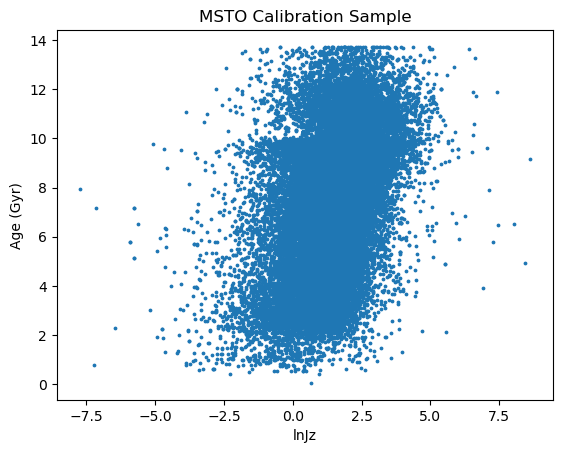

In [17]:
plt.scatter(lnJz, age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

plt.title('MSTO Calibration Sample')

Calibrate monotonic spline model

In [18]:
import jax.numpy as jnp
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

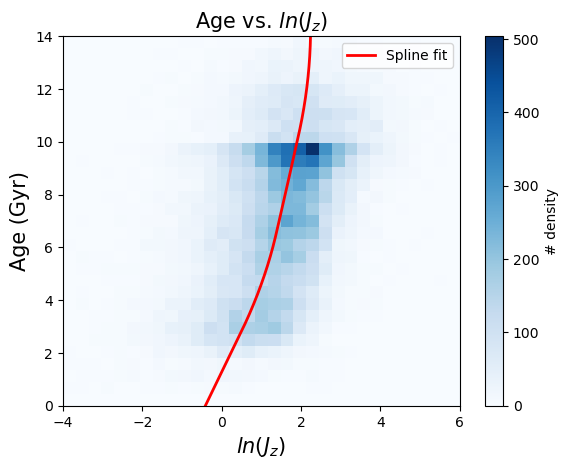

In [19]:
spline.plot_fit()

In [20]:
import arviz as az
az.summary(spline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.255,0.010,1.236,1.271,0.000,0.000,5664.0,2654.0,1.0
age_knot_vals[0],-0.761,0.062,-0.875,-0.640,0.001,0.001,2114.0,2235.0,1.0
age_knot_vals[1],0.331,0.014,0.306,0.358,0.000,0.000,1926.0,2156.0,1.0
age_knot_vals[2],0.151,0.009,0.135,0.167,0.000,0.000,1907.0,2612.0,1.0
age_knot_vals[3],0.142,0.009,0.125,0.159,0.000,0.000,3091.0,2561.0,1.0
age_knot_vals[4],0.006,0.006,0.000,0.016,0.000,0.000,4390.0,2103.0,1.0
dens_knot_vals[0],-9.359,0.644,-10.000,-8.180,0.008,0.006,3653.0,1761.0,1.0
dens_knot_vals[1],3.329,0.165,3.011,3.626,0.002,0.002,5271.0,2821.0,1.0
dens_knot_vals[2],5.670,0.051,5.578,5.770,0.001,0.000,5983.0,2915.0,1.0
dens_knot_vals[3],7.612,0.024,7.566,7.655,0.000,0.000,7398.0,2942.0,1.0


In [23]:
spline.write(directory='../MSTO_spline_model/')

In [24]:
newspline = zoomies.read(directory='../MSTO_spline_model/')

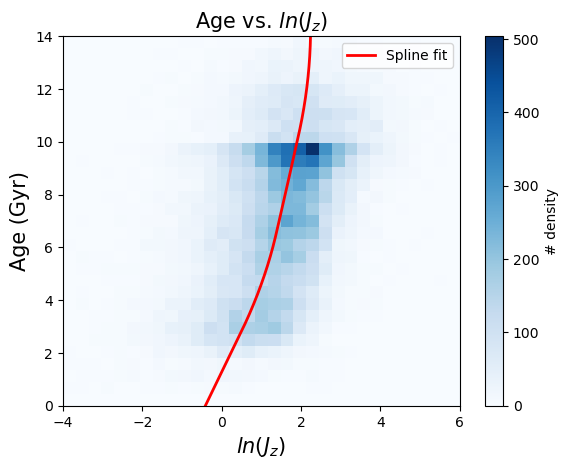

In [25]:
newspline.plot_fit()

In [26]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

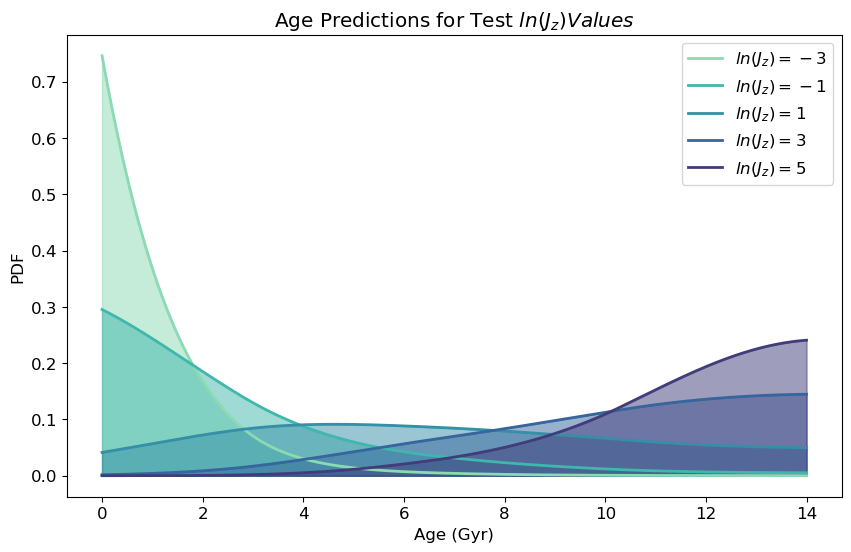

In [27]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

# Generate Fake Sample

Read in data and calculate actions

In [12]:
age = np.random.uniform(0,50,size=10000)
lnJz = np.random.uniform(0,50,size=10000)

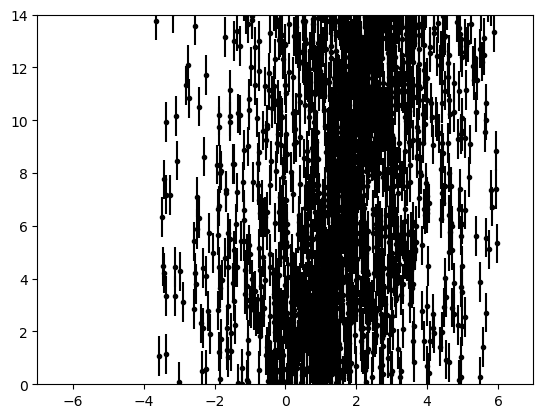

In [23]:

# Choose the "true" parameters.
m_true = 8
b_true = -6.5
#f_true = 3

# Generate some synthetic data from the model.
N = 10000
x = np.sort(np.random.uniform(-4,6,size=N))
yerr = 0.1 + 0.5 * np.random.uniform(0,50,size=N)
y = m_true * x + b_true
#y += f_true * y * np.random.randn(N)
y += yerr * np.random.randn(N)

yerr = 0.75

x = x[np.where(y > 0)[0]]
y = y[np.where(y > 0)[0]]

#plt.scatter(x, y)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.hist2d(x,y)

plt.ylim(0,14)
plt.xlim(-7,7)


lnJz = x
age = y
age_err = yerr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

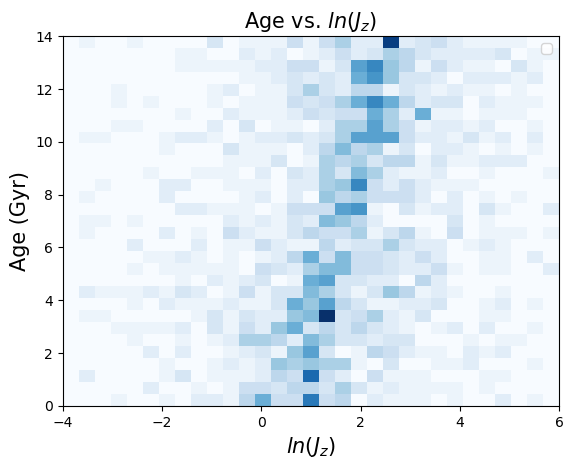

In [24]:
plt.hist2d(lnJz, age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 14, 32)), cmap='Blues')

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
#plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

In [28]:
np.savetxt('lnJz.txt', lnJz)
np.savetxt('age.txt', age)

Calibrate monotonic spline model

In [29]:
import jax.numpy as jnp
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

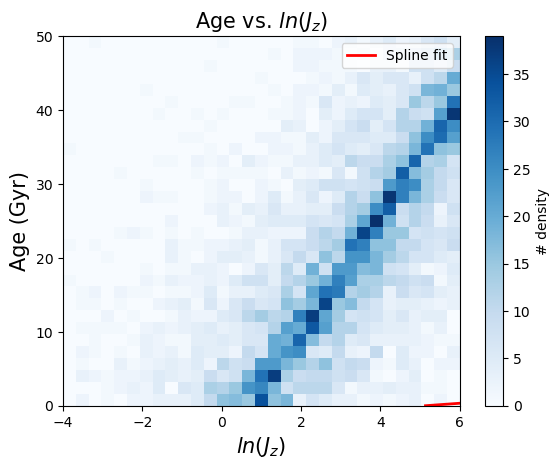

In [35]:
spline.plot_fit()

In [31]:
import arviz as az
az.summary(spline.inf_data)

/Users/ssagear/opt/anaconda3/envs/mdwarf/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,867.906,674.261,193.730,1542.082,475.820,402.893,2.0,2.0,7.011091e+15
age_knot_vals[0],2.225,0.325,1.900,2.550,0.230,0.194,3.0,21.0,1.870000e+00
age_knot_vals[1],1.781,0.804,0.977,2.584,0.567,0.480,2.0,17.0,2.760000e+00
age_knot_vals[2],2.301,1.611,0.691,3.912,1.137,0.962,2.0,2.0,2.340000e+00
age_knot_vals[3],3.211,0.510,2.700,3.721,0.360,0.305,2.0,13.0,2.780000e+00
age_knot_vals[4],2.583,0.417,2.165,3.000,0.294,0.249,2.0,11.0,2.420000e+00
dens_knot_vals[0],44.118,10.947,33.154,55.070,7.725,6.541,2.0,11.0,2.870000e+00
dens_knot_vals[1],1.179,1.356,-0.177,2.535,0.957,0.810,2.0,2.0,7.011091e+15
dens_knot_vals[2],6.694,0.556,6.136,7.250,0.393,0.332,3.0,11.0,2.270000e+00
dens_knot_vals[3],4.631,0.540,4.087,5.172,0.381,0.323,2.0,9.0,3.390000e+00


In [32]:
spline.write(directory='../Fake_spline_model/')

In [33]:
newspline = zoomies.read(directory='../Fake_spline_model/')

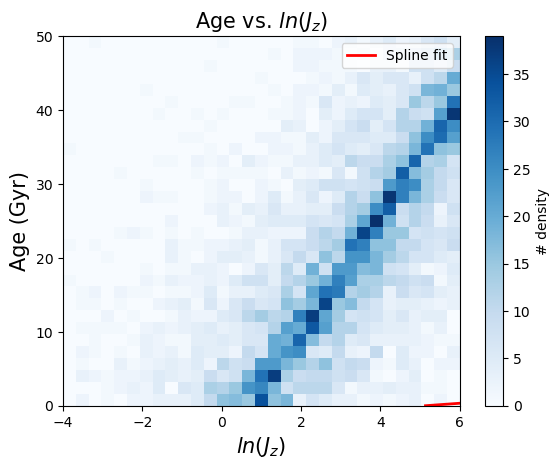

In [34]:
newspline.plot_fit()

In [150]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

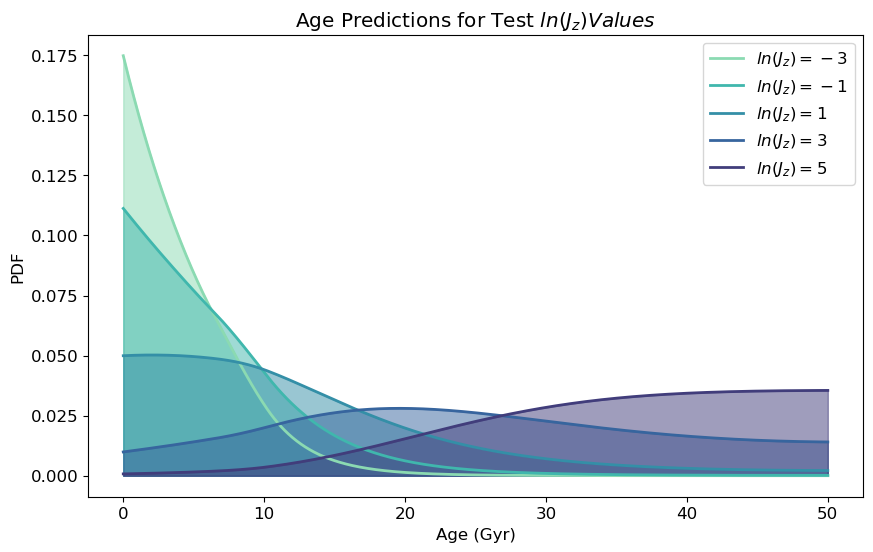

In [151]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')